In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#import cross_val_scoure
from sklearn.model_selection import cross_val_score



/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_43153/3079547319.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('../dataset/df_encoded.csv')
df_rescaled = pd.read_csv('../dataset/df_rescaled.csv')

# Linear Regression

In [31]:
X = df_rescaled.drop(columns=['Churn']).values.astype(np.float32)
y = df_rescaled['Churn'].values.astype(np.float32)

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Converti in tensori PyTorch
X_train_tensor = torch.from_numpy(X_train_reg)
y_train_tensor = torch.from_numpy(y_train_reg).unsqueeze(1)  # shape (n, 1)
X_test_tensor = torch.from_numpy(X_test_reg)
y_test_tensor = torch.from_numpy(y_test_reg).unsqueeze(1)

In [4]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)  # output non passato da sigmoid/logisti

In [5]:
model = LinearClassifier(input_dim=X_train_reg.shape[1])
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)


Epoch 0, Loss: 0.2876
Epoch 100, Loss: 0.1405
Epoch 200, Loss: 0.1404
Epoch 300, Loss: 0.1404
Epoch 400, Loss: 0.1404
Epoch 500, Loss: 0.1404
Epoch 600, Loss: 0.1404
Epoch 700, Loss: 0.1404
Epoch 800, Loss: 0.1404
Epoch 900, Loss: 0.1404


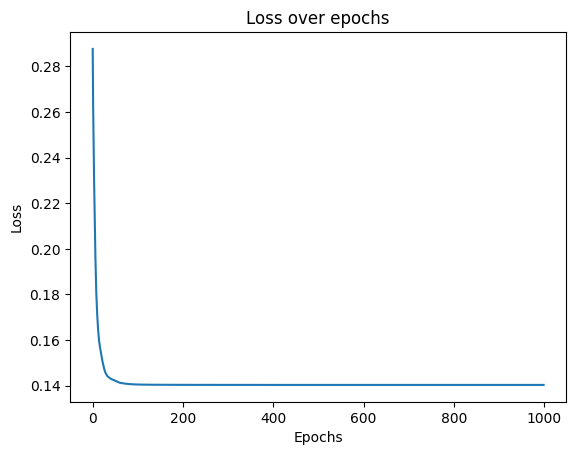

In [6]:
n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [7]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    preds = (outputs > 0.5).float()
    accuracy = (preds == y_test_tensor).float().mean()
    print(f"Test accuracy: {accuracy.item():.4f}")

Test accuracy: 0.8069


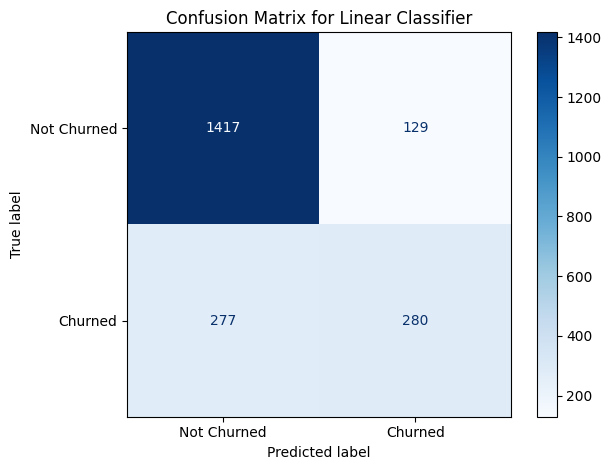

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.84      0.92      0.87      1546
     Churned       0.68      0.50      0.58       557

    accuracy                           0.81      2103
   macro avg       0.76      0.71      0.73      2103
weighted avg       0.80      0.81      0.80      2103



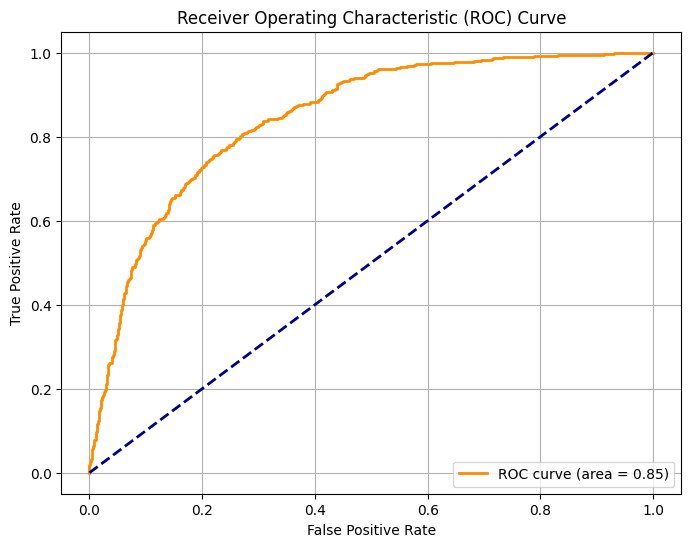

In [8]:
# Generate confusion matrix
cm = confusion_matrix(y_test_reg, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churned", "Churned"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Linear Classifier")
plt.tight_layout()
plt.savefig('../figures/classification/confusion_matrix_linear_classifier.png')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_reg, preds, target_names=["Not Churned", "Churned"]))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_reg, outputs.numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Logistic Regression

In [9]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [10]:
model = LogisticRegressionModel(X_train_tensor.shape[1])
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
losses = []

for epoch in range(5000):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.7222
Epoch 100, Loss: 0.4355
Epoch 200, Loss: 0.4244
Epoch 300, Loss: 0.4213
Epoch 400, Loss: 0.4204
Epoch 500, Loss: 0.4200
Epoch 600, Loss: 0.4197
Epoch 700, Loss: 0.4195
Epoch 800, Loss: 0.4192
Epoch 900, Loss: 0.4190
Epoch 1000, Loss: 0.4188
Epoch 1100, Loss: 0.4185
Epoch 1200, Loss: 0.4183
Epoch 1300, Loss: 0.4181
Epoch 1400, Loss: 0.4179
Epoch 1500, Loss: 0.4178
Epoch 1600, Loss: 0.4176
Epoch 1700, Loss: 0.4174
Epoch 1800, Loss: 0.4173
Epoch 1900, Loss: 0.4172
Epoch 2000, Loss: 0.4170
Epoch 2100, Loss: 0.4169
Epoch 2200, Loss: 0.4169
Epoch 2300, Loss: 0.4168
Epoch 2400, Loss: 0.4167
Epoch 2500, Loss: 0.4167
Epoch 2600, Loss: 0.4166
Epoch 2700, Loss: 0.4166
Epoch 2800, Loss: 0.4165
Epoch 2900, Loss: 0.4165
Epoch 3000, Loss: 0.4165
Epoch 3100, Loss: 0.4165
Epoch 3200, Loss: 0.4164
Epoch 3300, Loss: 0.4164
Epoch 3400, Loss: 0.4164
Epoch 3500, Loss: 0.4164
Epoch 3600, Loss: 0.4164
Epoch 3700, Loss: 0.4164
Epoch 3800, Loss: 0.4164
Epoch 3900, Loss: 0.4164
Epoch 4000, 

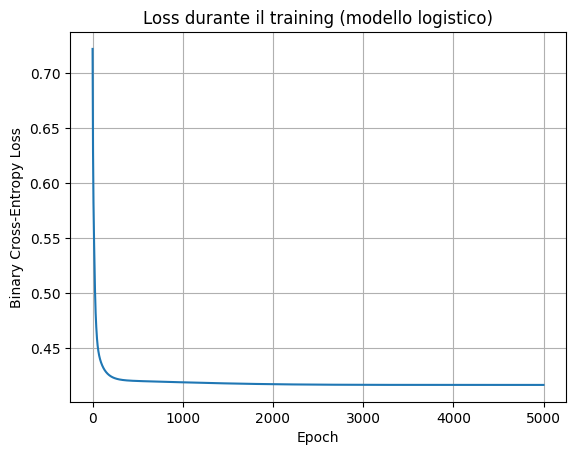

In [12]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss durante il training (modello logistico)")
plt.grid(True)
plt.show()


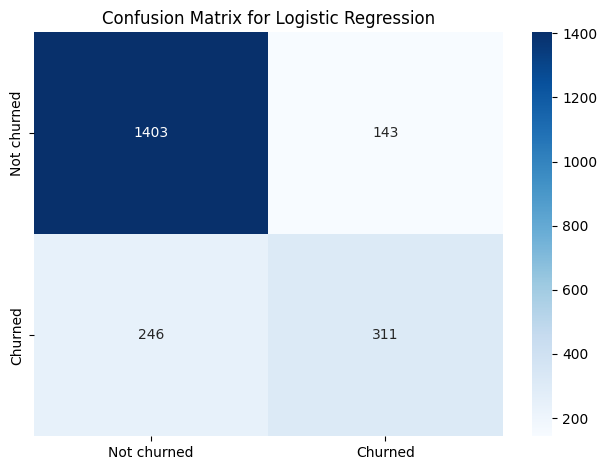

              precision    recall  f1-score   support

    No churn       0.85      0.91      0.88      1546
       Churn       0.69      0.56      0.62       557

    accuracy                           0.82      2103
   macro avg       0.77      0.73      0.75      2103
weighted avg       0.81      0.82      0.81      2103

AUC: 0.851


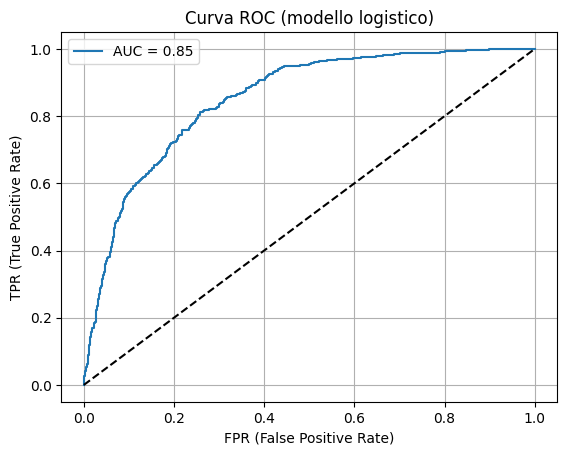

In [13]:
# Previsioni
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred_class = (y_pred_probs >= 0.5).astype(int)

# Matrice di confusione
cm = confusion_matrix(y_test_tensor.numpy(), y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not churned', 'Churned'], yticklabels=['Not churned', 'Churned'])
plt.title("Confusion Matrix for Logistic Regression")
plt.tight_layout()
plt.savefig('../figures/classification/confusion_matrix_logistic_regression.png')
plt.show()

print(classification_report(y_test_tensor.numpy(), y_pred_class, target_names=["No churn", "Churn"]))

auc_d = roc_auc_score(y_test_tensor.numpy(), y_pred_probs)
print(f"AUC: {auc_d:.3f}")

fpr, tpr, _ = roc_curve(y_test_tensor.numpy(), y_pred_probs)
plt.plot(fpr, tpr, label=f'AUC = {auc_d:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # linea casuale
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC (modello logistico)")
plt.legend()
plt.grid(True)
plt.show()

# Decision Trees

In [14]:
df_class_ref = df.copy()

In [32]:
refvar="Churn"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

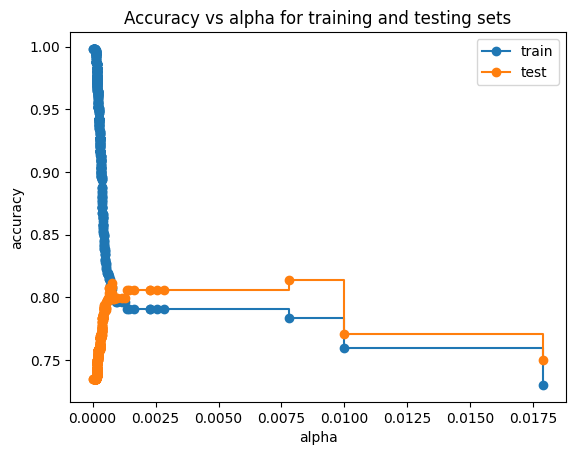

<Axes: xlabel='alpha'>

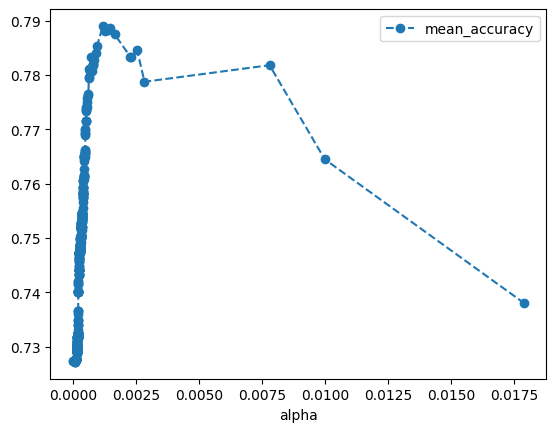

In [16]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_43153/3313328189.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ideal_ccp_alpha = float(maxalpha)


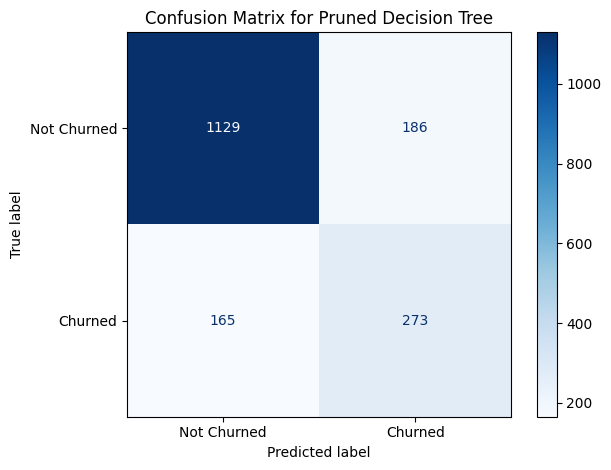

Accuracy 0.7997718197375927
F1-score 0.608695652173913
              precision    recall  f1-score   support

       False       0.87      0.86      0.87      1315
        True       0.59      0.62      0.61       438

    accuracy                           0.80      1753
   macro avg       0.73      0.74      0.74      1753
weighted avg       0.80      0.80      0.80      1753

0.8240333697935657


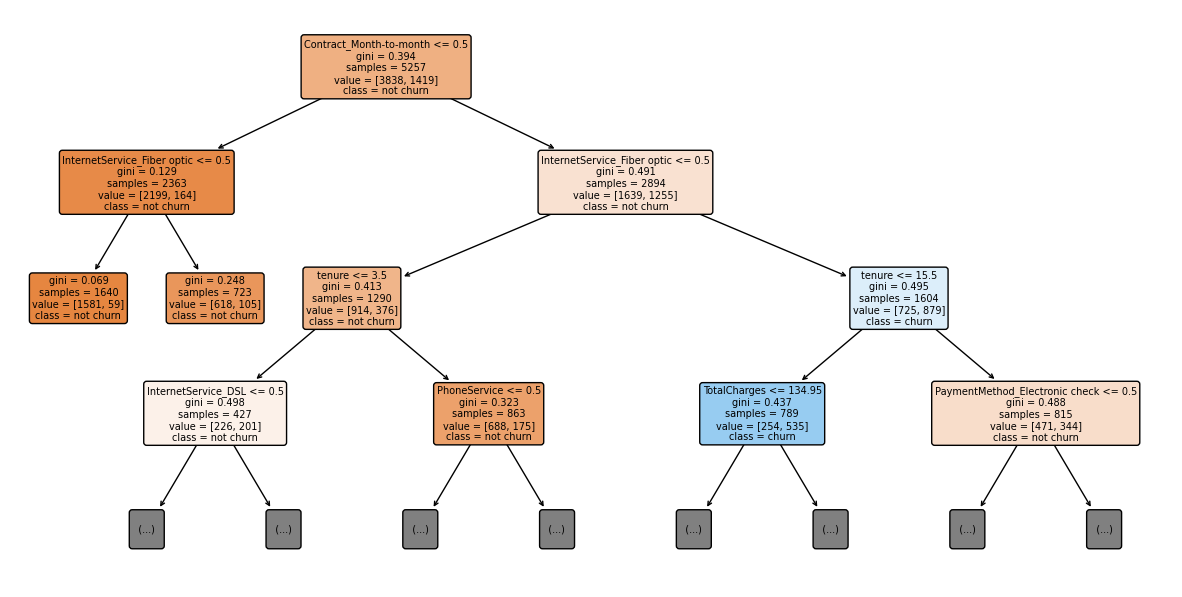

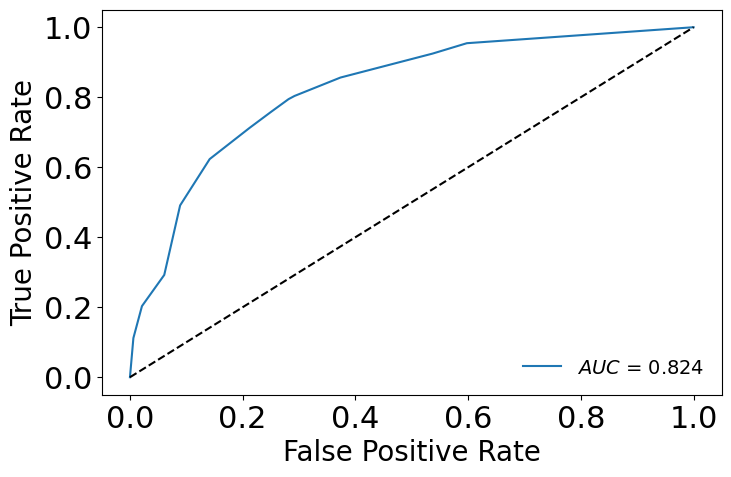

In [17]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

# confusion matrix
cm = confusion_matrix(y_test, clf_dt_pruned.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churned", "Churned"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Pruned Decision Tree")
plt.tight_layout()
plt.savefig('../figures/classification/confusion_matrix_pruned_decision_tree.png')
plt.show()


plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not churn","churn"],
          feature_names=X.columns,
          max_depth=3,
          fontsize=7)

y_pred = clf_dt_pruned.predict(X_test)
plt.savefig('plot_of_tree.pdf')

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

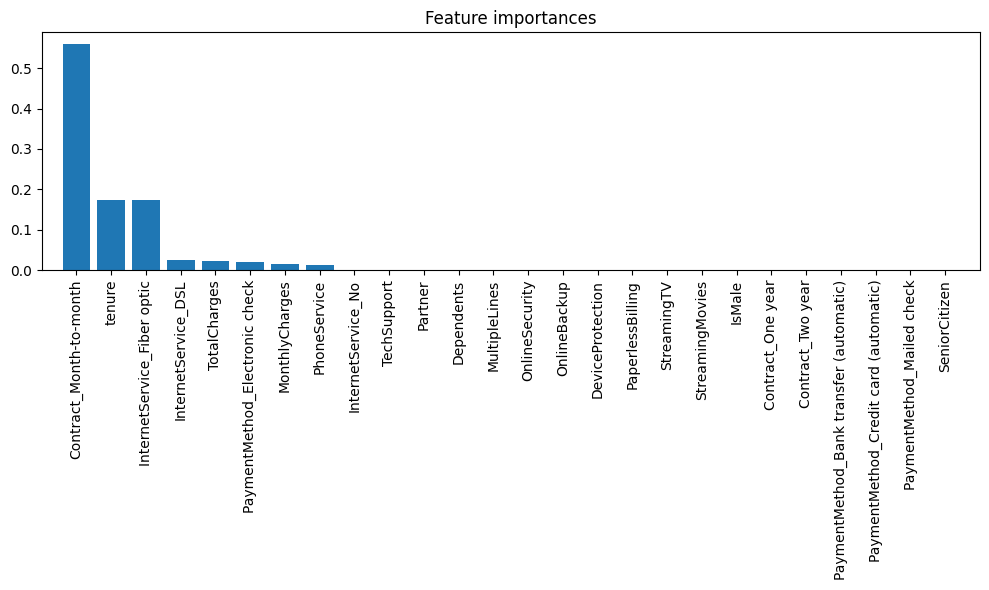

In [18]:
#print feature importance
importances = clf_dt_pruned.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


# XGBoost

In [25]:
import xgboost as xgb

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/usr/local/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: @rpath/libomp.dylib\n  Referenced from: /usr/local/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


Accuracy 0.7866514546491729
F1-score 0.5325000000000001
              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1315
        True       0.59      0.49      0.53       438

    accuracy                           0.79      1753
   macro avg       0.71      0.69      0.70      1753
weighted avg       0.78      0.79      0.78      1753

0.824086323940483


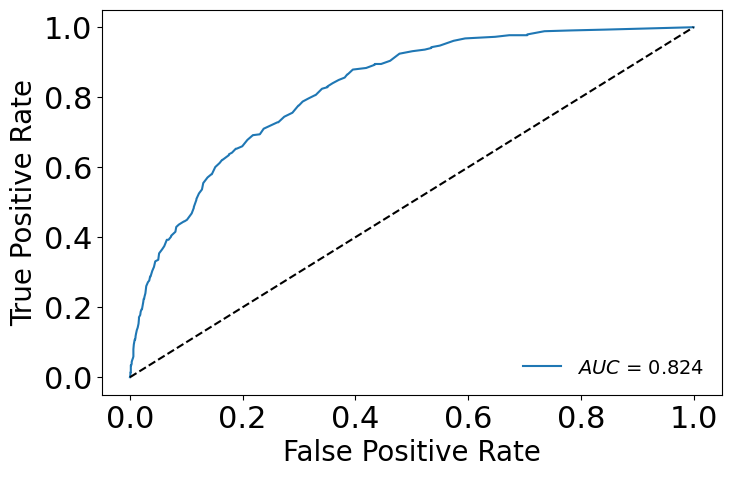

In [20]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_score = clf.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [21]:
#set up search grid
#Number of search trees
n_estimators=range(50,100)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = range(4,8)
# Minimum number of samples required to split a node
min_samples_split = range(2,6)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,5)
# Method of selecting samples for training each tree
bootstrap = [True, False]
#criterion
criterion=['gini','entropy']
#create the random grid
random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap,
              'criterion':criterion}
print(random_grid)

{'n_estimators': range(50, 100), 'max_features': ['auto', 'sqrt'], 'max_depth': range(4, 8), 'min_samples_split': range(2, 6), 'min_samples_leaf': range(1, 5), 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, n_iter=100,random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=False, criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=54; total time=   0.7s
[CV] END bootstrap=False, criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=54; total time=   0.8s
[CV] END bootstrap=False, criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=54; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=95; total time=   1.0s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=60; total time=   1.0s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=60; total time=   1.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, min_samples_l

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/site-packages/sklearn/util

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(4, 8),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(2, 6),
                                        'n_estimators': range(50, 100)},
                   random_state=42, verbose=2)

In [23]:
#best params
params = rf_random.best_params_
params

{'n_estimators': 85,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 7,
 'criterion': 'entropy',
 'bootstrap': True}

In [24]:
rfc = RandomForestClassifier(**params,random_state=42)
rfc.fit(X_train,y_train)


RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=5,
                       n_estimators=85, random_state=42)

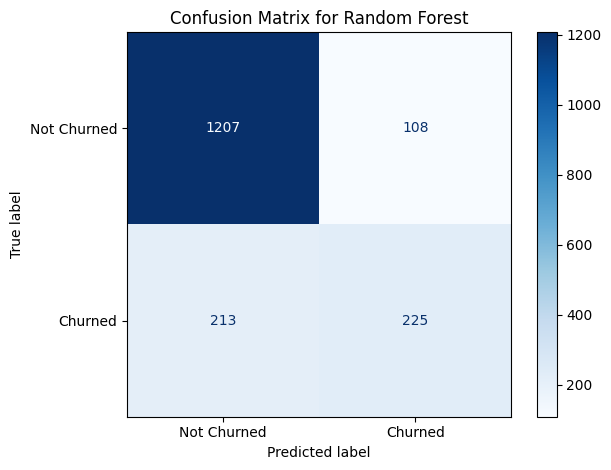

In [25]:
# confusion matrix
cm = confusion_matrix(y_test, rfc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churned", "Churned"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest")
plt.tight_layout()
plt.savefig('../figures/classification/confusion_matrix_random_forest.png')
plt.show()


Accuracy 0.8168853394181403
F1-score 0.5836575875486382
              precision    recall  f1-score   support

       False       0.85      0.92      0.88      1315
        True       0.68      0.51      0.58       438

    accuracy                           0.82      1753
   macro avg       0.76      0.72      0.73      1753
weighted avg       0.81      0.82      0.81      1753

0.8507413580568433


<Figure size 640x480 with 0 Axes>

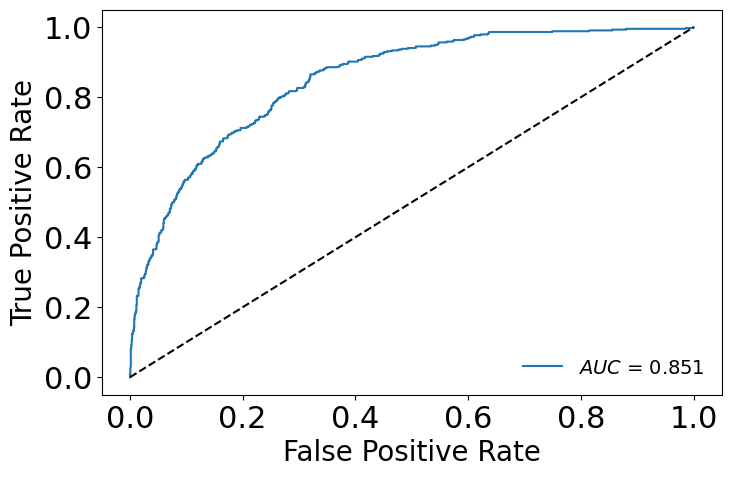

In [26]:
#plot roc curve
y_pred = rfc.predict(X_test)
plt.savefig('plot_of_tree.pdf')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_score = rfc.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()


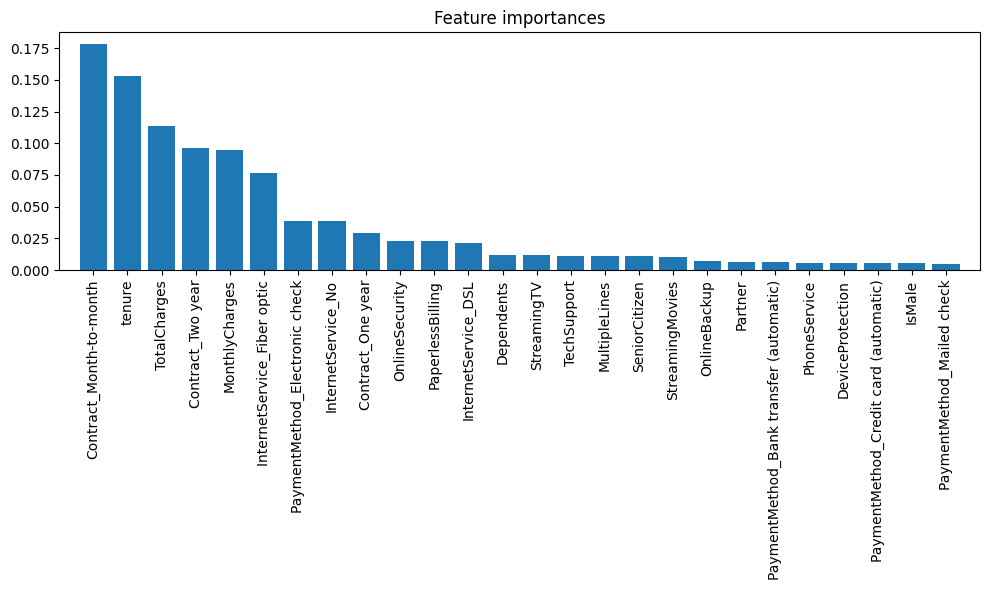

In [27]:
#plot feature importance
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
plt.figure(figsize=(10,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


# k Nearest Neighbors


In [28]:
# import kNN
from sklearn.neighbors import KNeighborsClassifier

/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_43153/3922671116.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ideal_ccp_alpha = float(maxalpha)


0.0017236624674571571
              precision    recall  f1-score   support

       False       0.88      0.85      0.86      1315
        True       0.59      0.65      0.62       438

    accuracy                           0.80      1753
   macro avg       0.73      0.75      0.74      1753
weighted avg       0.81      0.80      0.80      1753

16
              precision    recall  f1-score   support

       False       0.83      0.96      0.89      1315
        True       0.77      0.40      0.53       438

    accuracy                           0.82      1753
   macro avg       0.80      0.68      0.71      1753
weighted avg       0.81      0.82      0.80      1753



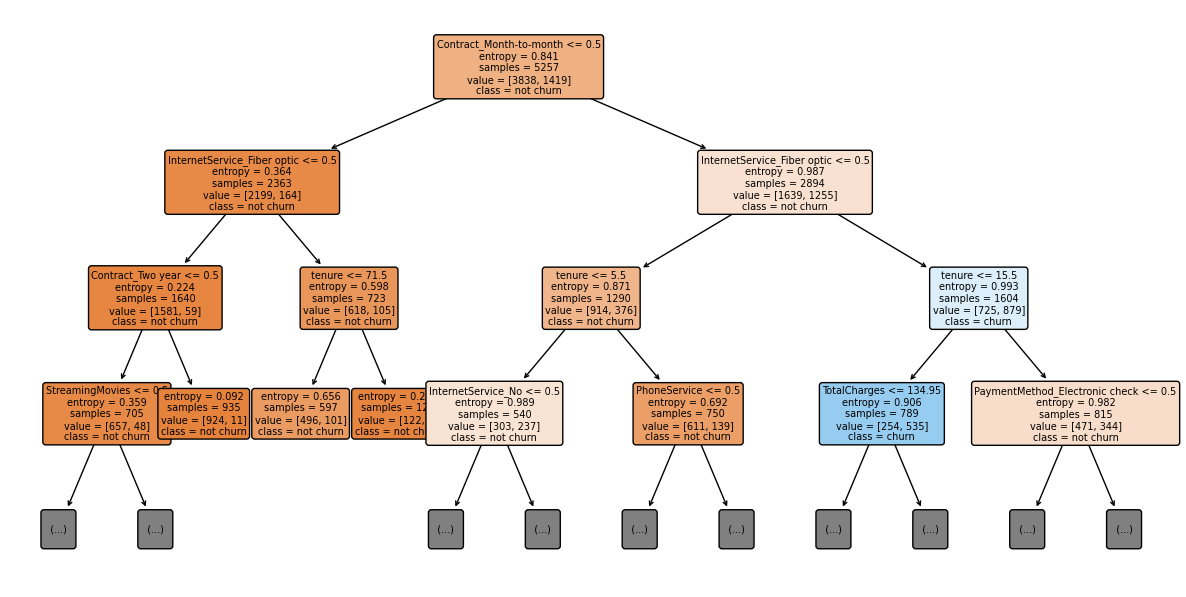

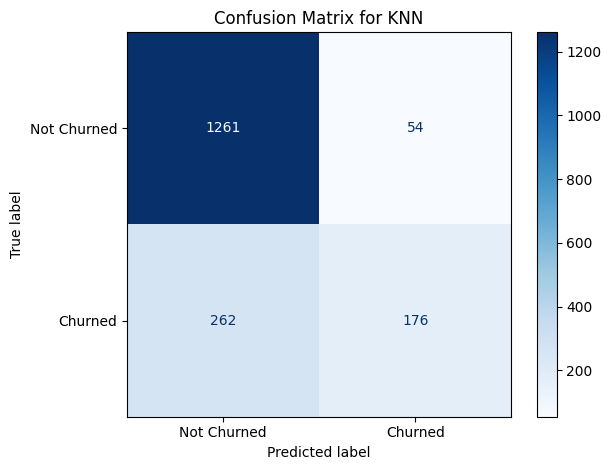

              precision    recall  f1-score   support

       False       0.85      0.92      0.88      1315
        True       0.68      0.51      0.58       438

    accuracy                           0.82      1753
   macro avg       0.76      0.72      0.73      1753
weighted avg       0.81      0.82      0.81      1753



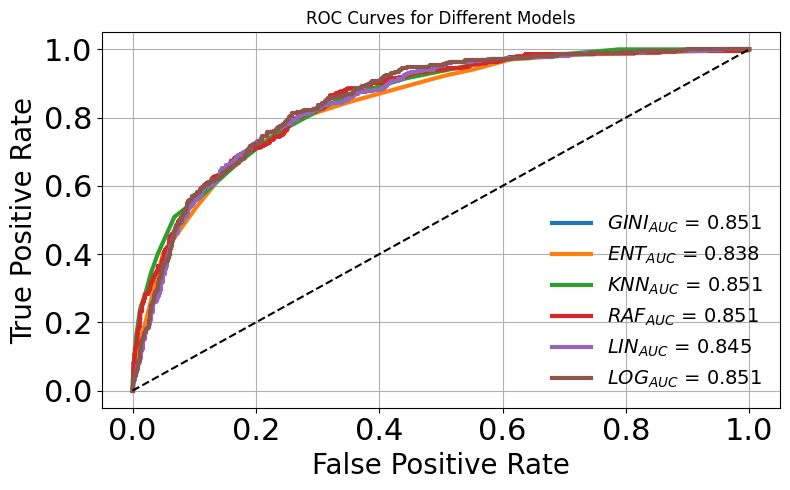

In [38]:
#ROC for Decision Tree (Gini)
fpr_0, tpr_0, th_0 = roc_curve(y_test, y_score[:,1])

roc_auc_0 = auc(fpr_0, tpr_0) 

#ROC for Linear Classifier
fpr_1, tpr_1, _ = roc_curve(y_test_reg, outputs.numpy())
roc_auc_1 = auc(fpr_1, tpr_1)
#ROC for Logistic Regression
fpr_2, tpr_2, _ = roc_curve(y_test_tensor.numpy(), y_pred_probs)
roc_auc_2 = auc(fpr_2, tpr_2)

#Entropy
clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])

indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)
print(ideal_ccp_alpha)


clf_dt_pruned = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_score = clf_dt_pruned.predict_proba(X_test)

fpr_en, tpr_en, th_en = roc_curve(y_test, y_score[:,1])

roc_auc_en = auc(fpr_en, tpr_en)

y_pred = clf_dt_pruned.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not churn","churn"],
          feature_names=X.columns,
          max_depth=3,
          fontsize=7)


#KNN, find best score
acc = []
# Will take some time

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

print(acc.index(max(acc)))
clf_knn = KNeighborsClassifier(n_neighbors=acc.index(max(acc)))
clf_knn.fit(X, y)

y_pred = clf_knn.predict(X_train)
y_score = clf_knn.predict_proba(X_test)

fpr_KNN, tpr_KNN, th_KNN = roc_curve(y_test, y_score[:,1])

roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

y_pred = clf_knn.predict(X_test)

print(classification_report(y_test, y_pred))

#plot confusion matrix for knn
cm = confusion_matrix(y_test, clf_knn.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churned", "Churned"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for KNN")
plt.tight_layout()
plt.savefig('../figures/classification/confusion_matrix_knn.png')
plt.show()

# Instantiate model with 380 decision trees
model = RandomForestClassifier(**params,random_state=42)
# Train the model on training data
ra=model.fit(X_train, y_train)

y_score = model.predict_proba(X_test)

fpr_RF, tpr_RF, th_RF = roc_curve(y_test, y_score[:,1])

roc_auc_RF = auc(fpr_RF, tpr_RF)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(8,5))

plt.plot(fpr_0, tpr_0,lw=3,label='$GINI_{AUC}$ = %.3f' % (roc_auc_0))
plt.plot(fpr_en, tpr_en,lw=3,label='$ENT_{AUC}$ = %.3f' % (roc_auc_en))
plt.plot(fpr_KNN, tpr_KNN,lw=3,label='$KNN_{AUC}$ = %.3f' % (roc_auc_KNN))
plt.plot(fpr_RF, tpr_RF,lw=3,label='$RAF_{AUC}$ = %.3f' % (roc_auc_RF))
plt.plot(fpr_1, tpr_1,lw=3,label='$LIN_{AUC}$ = %.3f' % (roc_auc_1))
plt.plot(fpr_2, tpr_2,lw=3,label='$LOG_{AUC}$ = %.3f' % (roc_auc_2))
#plt.plot(fpr_c, tpr_c,lw=3,label='$GR_{AUC}$ = %.3f' % (roc_auc_c))
plt.legend(loc="lower right", fontsize=14, frameon=False)


plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('ROC Curves for Different Models')
plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/classification/roc_curves.pdf')
plt.show()